### Import libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import seaborn

### Read data

In [ ]:
df_military = pd.read_csv("data/military_expenditure.csv", skiprows=4)
df_imports = pd.read_csv("data/imports.csv", skiprows=4)
df_gdp = pd.read_csv("data/gdp.csv", skiprows=4)
df_gdp.head()

In [ ]:
import pandas as pd
import numpy as np

# Read the datasets into DataFrames
military_df = pd.read_csv("data/military_expenditure.csv", skiprows=4)
gdp_df = pd.read_csv("data/gdp.csv", skiprows=4)
imports_df = pd.read_csv("data/imports.csv", skiprows=4)

# Define the years to consider
years = [str(year) for year in range(1990, 2024)]

# Filter only relevant columns
military_data = military_df[['Country Name'] + years]
imports_data = imports_df[['Country Name'] + years]

# Merge datasets on 'Country Name'
merged_df = pd.merge(military_data, imports_data, on='Country Name', suffixes=('_military', '_imports'))

# Function to compute normalized cross-correlation
def normalized_cross_correlation(x, y):
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    return np.correlate(x, y, mode='full') / len(x)

# Compute cross-correlation for each country
cross_corr_results = []

for index, row in merged_df.iterrows():
    country = row['Country Name']
    military = row[[f'{year}_military' for year in years]].astype(float)
    imports = row[[f'{year}_imports' for year in years]].astype(float)

    if military.isnull().sum() > 0 or imports.isnull().sum() > 0:
        continue  # Skip countries with missing data

    cross_corr = normalized_cross_correlation(military.values, imports.values)
    max_corr = np.max(cross_corr)
    lag = np.argmax(cross_corr) - (len(military) - 1)

    cross_corr_results.append((country, max_corr, lag))

# Convert results to DataFrame
cross_corr_df = pd.DataFrame(cross_corr_results, columns=['Country', 'Max Cross-Correlation', 'Lag at Max'])

# Display top countries by cross-correlation
print(cross_corr_df.sort_values(by='Max Cross-Correlation', ascending=False).head(20))

 ### Interpretation
Ein Wert nahe 1 zeigt eine hohe Korrelation zwischen den Militärausgaben und dem Importanteil am GDP an. Was konkret bedeutet, dass wenn
einer dieser Werte steigt oder fällt der andere Wert nachfolgt.

### Granger Kausalität

In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.stattools import grangercausalitytests

# # Read the datasets into DataFrames
# military_df = pd.read_csv("Military/military.csv", skiprows=4)
# gdp_df = pd.read_csv("GDP/GDP.csv", skiprows=4)
# imports_df = pd.read_csv("Imports/imports.csv", skiprows=4)

# # Define the years to consider
# years = [str(year) for year in range(1990, 2024)]

# # Filter only relevant columns
# military_data = military_df[['Country Name'] + years]
# imports_data = imports_df[['Country Name'] + years]

# # Merge datasets on 'Country Name'
# merged_df = pd.merge(military_data, imports_data, on='Country Name', suffixes=('_military', '_imports'))

# # Compute Granger causality for each country
# granger_results = []

# for index, row in merged_df.iterrows():
#     country = row['Country Name']
#     military = row[[f'{year}_military' for year in years]].astype(float)
#     imports = row[[f'{year}_imports' for year in years]].astype(float)

#     if military.isnull().sum() > 0 or imports.isnull().sum() > 0:
#         continue  # Skip countries with missing data

#     try:
#         data = pd.DataFrame({"military": military.values, "imports": imports.values})
#         # Granger test: does military spending help predict imports?
#         test_result = grangercausalitytests(data, maxlag=5)
#         p_values = [round(test_result[i+1][0]['ssr_ftest'][1], 4) for i in range(5)]
#         granger_results.append((country, p_values))
#     except Exception as e:
#         continue  # Skip if test fails

# # Convert results to DataFrame
# granger_df = pd.DataFrame(granger_results, columns=['Country', 'P-Values by Lag'])

# # Display top countries where military spending Granger-causes imports (lowest p-values)
# print(granger_df.tail(20))

### Granger Kausalität für ein einzelnen Staat

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

country_code = "DEU"

# --- Hilfsfunktion zum Einlesen und Umformen ---
def load_world_bank_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=4)
    df = df.drop(columns=[col for col in df.columns if col.startswith("Unnamed")], errors="ignore")
    return df

def reshape_indicator(df: pd.DataFrame, value_name: str) -> pd.DataFrame:
    df_usa = df[df["Country Code"] == country_code]
    df_long = df_usa.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name=value_name
    )
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long = df_long.dropna(subset=["Year", value_name])
    df_long["Year"] = df_long["Year"].astype(int)
    return df_long[["Year", value_name]]

# --- Dateien einlesen ---
military_df = load_world_bank_csv("data/military_expanditure.csv")
export_df = load_world_bank_csv("data/exports.csv")
import_df = load_world_bank_csv("data/imports.csv")
gdp_df = load_world_bank_csv("data/gdp.csv")

# --- USA-spezifische Zeitreihen extrahieren ---
military_usa = reshape_indicator(military_df, "Military")
export_usa = reshape_indicator(export_df, "Export_pct_GDP")
import_usa = reshape_indicator(import_df, "Import_pct_GDP")
gdp_usa = reshape_indicator(gdp_df, "GDP")

# --- Daten zusammenführen ---
merged_df = military_usa.merge(gdp_usa, on="Year", how="inner") \
                        .merge(export_usa, on="Year", how="inner") \
                        .merge(import_usa, on="Year", how="inner")

# --- Granger-Kausalität: Military → andere Variablen ---
target_vars = ["GDP", "Export_pct_GDP", "Import_pct_GDP"]
results = {}

for target in target_vars:
    test_data = merged_df[["Military", target]].dropna()
    # Achtung: Reihenfolge im Test ist [Ziel, Ursache]
    test_result = grangercausalitytests(test_data[[target, "Military"]], maxlag=5)
    p_values = {lag: round(test_result[lag][0]['ssr_ftest'][1], 4) for lag in test_result}
    results[target] = p_values

# --- Ergebnisse als DataFrame ---
granger_df = pd.DataFrame(results).T
granger_df.columns = [f"Lag {i}" for i in granger_df.columns]
print(granger_df)

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# country_code = "DEU"
maxlag = 3

# --- Hilfsfunktion zum Einlesen und Umformen ---
def load_world_bank_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=4)
    df = df.drop(columns=[col for col in df.columns if col.startswith("Unnamed")], errors="ignore")
    df = df.dropna(thresh=df.shape[1] - 40)
    return df

def reshape_indicator(df: pd.DataFrame, value_name: str, country_code: str) -> pd.DataFrame:
    df_usa = df[df["Country Code"] == country_code]
    df_long = df_usa.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name=value_name
    )
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long = df_long.dropna(subset=["Year", value_name])
    df_long["Year"] = df_long["Year"].astype(int)
    return df_long[["Year", value_name]]

# --- Dateien einlesen ---
military_df = load_world_bank_csv("data/military_expanditure.csv")
export_df = load_world_bank_csv("data/exports.csv")
import_df = load_world_bank_csv("data/imports.csv")
gdp_df = load_world_bank_csv("data/gdp.csv")

# --- USA-spezifische Zeitreihen extrahieren ---
def calc(country_code):
    military_usa = reshape_indicator(military_df, "Military", country_code)
    export_usa = reshape_indicator(export_df, "Export_pct_GDP", country_code)
    import_usa = reshape_indicator(import_df, "Import_pct_GDP", country_code)
    gdp_usa = reshape_indicator(gdp_df, "GDP", country_code)
    
    # --- Daten zusammenführen ---
    merged_df = military_usa.merge(gdp_usa, on="Year", how="inner") \
                            .merge(export_usa, on="Year", how="inner") \
                            .merge(import_usa, on="Year", how="inner")
    
    # --- Granger-Kausalität: Military → andere Variablen ---
    target_vars = ["GDP", "Export_pct_GDP", "Import_pct_GDP"]
    results = {}
    
    for target in target_vars:
        test_data = merged_df[["Military", target]].dropna()
        # Achtung: Reihenfolge im Test ist [Ziel, Ursache]
        test_result = grangercausalitytests(test_data[[target, "Military"]], maxlag=maxlag)
        p_values = {lag: round(test_result[lag][0]['ssr_ftest'][1], 4) for lag in test_result}
        results[target] = p_values

    return results

# --- Ergebnisse als DataFrame ---
results = military_df["Country Code"].map(calc)

granger_df = pd.DataFrame(results).T
granger_df.columns = [f"Lag {i}" for i in granger_df.columns]
print(granger_df)

### Granger Kausalität für alle Staaten

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# Read the datasets into DataFrames
military_df = pd.read_csv("data/military_expenditure.csv", skiprows=4)
gdp_df = pd.read_csv("data/GDP.csv", skiprows=4)
imports_df = pd.read_csv("data/imports.csv", skiprows=4)
exports_df = pd.read_csv("data/exports.csv", skiprows=4)

# Define the years to consider
years = [str(year) for year in range(2000, 2024)]

# Filter only relevant columns
military_data = military_df[['Country Name'] + years]
imports_data = imports_df[['Country Name'] + years]
gdp_data = gdp_df[['Country Name'] + years]
exports_data = exports_df[['Country Name'] + years]

# Merge all datasets on 'Country Name'
merged_df = military_data.merge(imports_data, on='Country Name', suffixes=('_military', '_imports'))
merged_df = merged_df.merge(gdp_data, on='Country Name')
merged_df.rename(columns={year: f"{year}_gdp" for year in years}, inplace=True)
merged_df = merged_df.merge(exports_df, on='Country Name')
merged_df.rename(columns={year: f"{year}_exports" for year in years}, inplace=True)

# pd.set_option('display.max_columns', None)
# print(merged_df)
# merged_df.describe()

# Compute Granger causality for each country
granger_results = []

for index, row in merged_df.iterrows():
    country = row['Country Name']
    military = row[[f'{year}_military' for year in years]].astype(float)
    imports = row[[f'{year}_imports' for year in years]].astype(float)
    gdp = row[[f'{year}_gdp' for year in years]].astype(float)

    if military.isnull().any() or imports.isnull().any() or gdp.isnull().any():
        continue  # Skip countries with missing data

    try:
        data = pd.DataFrame({"imports": imports.values, "military": military.values})
        # Granger test: does military spending help predict imports?
        test_result = grangercausalitytests(data, maxlag=3)
        for lag in range(1, 4):
            p_value = round(test_result[lag][0]['ssr_ftest'][1], 4)
            granger_results.append({
                'Country': country,
                'KPI': 'Import',
                'Lag': lag,
                'P-Value': p_value
            })
    except Exception:
        pass
        # continue  # Skip if test fails

    try:
        data = pd.DataFrame({"exports": exports.values, "military": military.values})
        # Granger test: does military spending help predict exports?
        test_result = grangercausalitytests(data, maxlag=3)
        for lag in range(1, 4):
            p_value = round(test_result[lag][0]['ssr_ftest'][1], 4)
            granger_results.append({
                'Country': country,
                'KPI': 'Export',
                'Lag': lag,
                'P-Value': p_value
            })
    except Exception:
        pass
        # continue  # Skip if test fails

    try:
        data = pd.DataFrame({"gdp": gdp.values, "military": military.values})
        # Granger test: does military spending help predict gdp?
        test_result = grangercausalitytests(data, maxlag=3)
        for lag in range(1, 4):
            p_value = round(test_result[lag][0]['ssr_ftest'][1], 4)
            granger_results.append({
                'Country': country,
                'KPI': 'GDP',
                'Lag': lag,
                'P-Value': p_value
            })
    except Exception:
        pass
        # continue  # Skip if test fails

# Convert results to DataFrame
granger_df = pd.DataFrame(granger_results)

# Display top results
# print(granger_df.sort_values(by='P-Value').head(20))
print(granger_df[granger_df['KPI'] == 'GDP'])



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0537  , p=0.8191  , df_denom=20, df_num=1
ssr based chi2 test:   chi2=0.0618  , p=0.8038  , df=1
likelihood ratio test: chi2=0.0617  , p=0.8039  , df=1
parameter F test:         F=0.0537  , p=0.8191  , df_denom=20, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0493  , p=0.9520  , df_denom=17, df_num=2
ssr based chi2 test:   chi2=0.1276  , p=0.9382  , df=2
likelihood ratio test: chi2=0.1273  , p=0.9383  , df=2
parameter F test:         F=0.0493  , p=0.9520  , df_denom=17, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5487  , p=0.6572  , df_denom=14, df_num=3
ssr based chi2 test:   chi2=2.4692  , p=0.4809  , df=3
likelihood ratio test: chi2=2.3345  , p=0.5060  , df=3
parameter F test:         F=0.5487  , p=0.6572  , df_denom=14, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7827  , p=0.3868  , df_d

                         Country     KPI  Lag  P-Value
2    Africa Eastern and Southern  Import    3   0.6572
6                        Albania  Import    1   0.8419
192                      Algeria  Import    1   0.1614
14                    Arab World  Import    3   0.1643
20                     Argentina  Import    3   0.3559
..                           ...     ...  ...      ...
282               United Kingdom  Import    1   0.8504
882                United States  Import    1   0.0509
871          Upper middle income  Import    2   0.0072
878                      Uruguay  Import    3   0.3886
888                        World  Import    1   0.0027

[150 rows x 4 columns]


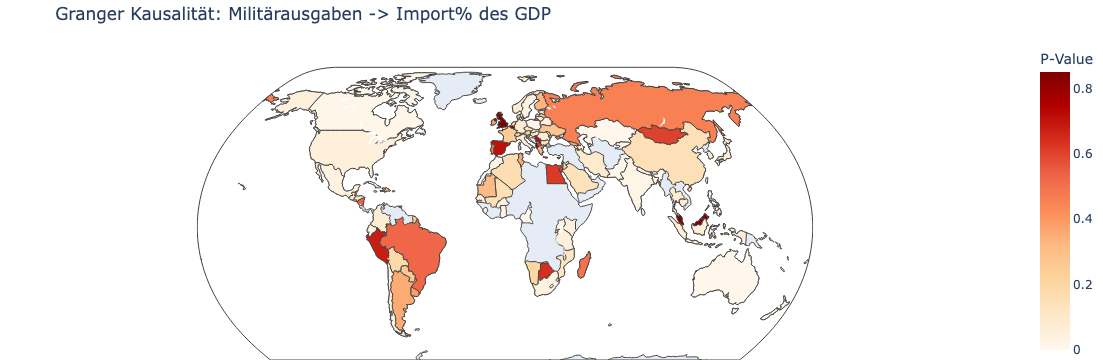

In [35]:
import pandas as pd
import pycountry
import plotly.express as px

df_map = granger_df[granger_df["KPI"] == "Import"]
df_map = df_map.loc[df_map.groupby('Country')['P-Value'].idxmin()]
print(df_map)

# 4) Interaktive Choropleth-Karte
fig = px.choropleth(
    df_map,
    locations='Country',
    locationmode='country names',
    color='P-Value',
    hover_name='Country',
    hover_data=['Lag'],
    color_continuous_scale='OrRd',
    projection='natural earth',
    title='Granger Kausalität: Militärausgaben -> Import% des GDP'
)

fig.update_geos(showcoastlines=True, showland=True, fitbounds='locations')
fig.update_layout(margin={'r':0,'t':40,'l':0,'b':0})
fig.show()

### Granger Kausalität: Militärausgaben -> Export% Anteil an GDP

                         Country  KPI  Lag  P-Value
3    Africa Eastern and Southern  GDP    1   0.3868
9                        Albania  GDP    1   0.1908
195                      Algeria  GDP    1   0.6704
17                    Arab World  GDP    3   0.0689
21                     Argentina  GDP    1   0.0604
..                           ...  ...  ...      ...
285               United Kingdom  GDP    1   0.8343
887                United States  GDP    3   0.1156
874          Upper middle income  GDP    2   0.0825
881                      Uruguay  GDP    3   0.4535
891                        World  GDP    1   0.1669

[150 rows x 4 columns]


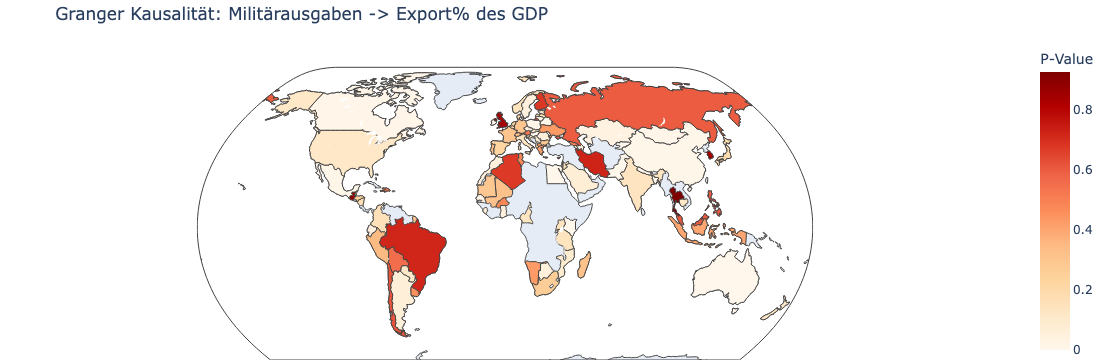

In [39]:
import pandas as pd
import pycountry
import plotly.express as px

df_map = granger_df[granger_df["KPI"] == "GDP"]
df_map = df_map.loc[df_map.groupby('Country')['P-Value'].idxmin()]
print(df_map)

# 4) Interaktive Choropleth-Karte
fig = px.choropleth(
    df_map,
    locations='Country',
    locationmode='country names',
    color='P-Value',
    hover_name='Country',
    hover_data=['Lag'],
    color_continuous_scale='OrRd',
    projection='natural earth',
    title='Granger Kausalität: Militärausgaben -> Export% des GDP'
)

fig.update_geos(showcoastlines=True, showland=True, fitbounds='locations')
fig.update_layout(margin={'r':0,'t':40,'l':0,'b':0})
fig.show()